# Load in the packages

In [100]:
# Standard library imports
import os

# Third-party library imports
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted  # For natural sorting
from tqdm import tqdm  # For progress bars in loops

# Define special characters
plus_minus = u"\u00B1"  # Unicode for ± symbol

# Load in the data files

In [101]:
# Determine the current working directory
path = os.getcwd()

# Extract sample names from the directory (only directories, no files)
sample_names = natsorted([n for n in os.listdir() if '.' not in n])

# Load the reference CSV file
ref_file = 'Current_vs_Power_20230323_REDO.csv'
if not os.path.exists(ref_file):
    raise FileNotFoundError(f"The reference CSV file {ref_file} is missing.")
    
ref = pd.read_csv(ref_file, index_col='current')
# Check if ref contains the required columns
if 'power' not in ref.columns:
    raise ValueError(f"The reference CSV file {ref_file} does not contain the 'power' column.")

# Construct fids dictionary mapping sample names to CSV file paths
fids = {n: natsorted([os.path.join(path, n, f) for f in os.listdir(os.path.join(path, n)) if os.path.splitext(f)[1] == '.csv']) for n in sample_names}

# Construct currents and powers dictionaries
currents = {n: [float(f.split('_')[-1][:-4]) for f in fids[n]] for n in sample_names}
powers = {n: np.array(ref['power'][currents[n]]) for n in sample_names}

# Define the functions for analysis

In [102]:
# Constants for PLQY calculation
SAMPLE_WL = 804
SAMPLE_RESP = 0.604
LASER_WL = 532
LASER_RESP = 0.3228

# Generate a color palette using Seaborn's "deep" palette
color_palette = sns.color_palette("deep", len(sample_names))
colors_seaborn = {sample: color_palette[i] for i, sample in enumerate(sample_names)}

In [103]:
def load_plqy(fid: str) -> pd.DataFrame:
    """Load PLQY data from a provided CSV file path.
    
    Args:
        fid (str): File path, should be .csv.

    Returns:
        pd.DataFrame: A DataFrame containing data related to PLQY.

    Raises:
        FileNotFoundError: If the provided file does not exist.
        ValueError: If the expected columns are not found in the data.
    """
    
    # Check if file exists
    if not os.path.exists(fid):
        raise FileNotFoundError(f"The file {fid} does not exist.")
    
    df = pd.read_csv(fid)
    
    # Check for expected columns in the data
    expected_columns = ['in_lp', 'out_lp', 'in_nolp', 'out_nolp', 'empty_nolp', 'empty_lp']
    for col in expected_columns:
        if col not in df.columns:
            raise ValueError(f"Expected column {col} not found in the data.")
    
    # Check for NaN values in the data
    if df.isna().any().any():
        raise ValueError(f"The data in {fid} contains NaN values which might affect calculations.")
    
    return df


    
def calc_plqy_deMello(data: pd.DataFrame, sample_wl: float, sample_resp: float, laser_wl: float, laser_resp: float):

    """A function to calculate the PLQY based in a publication by de Mello et al.
       The most widely used method for calculating PLQY.
       https://doi.org/10.1002/adma.19970090308

    Args:
        data (pd.DataFrame): dataframe loaded in using the load_plqy() function
        sample_wl (float): the peak emission wavelength of the sample
        sample_resp (float): the responsivity of the detector at sample_wl
        laser_wl (float): the emission wavelength of the laser. Probably 532.0nm
        laser_resp (float): the responsivity of the detector at the laser_wl

    Returns:
        tuple: (PLQY, PLQY error), reported as fractional, not percentage
    """
    # Use helper functions to break down complex calculations
    E_in = data['in_lp'].mean()
    E_in_err = data['in_lp'].std()/E_in

    E_out = data['out_lp'].mean()
    E_out_err = data['out_lp'].std()/E_out

    X_in = data['in_nolp'].mean() - E_in
    X_in_err = (data['in_nolp'].std()/X_in) + E_in_err

    X_out = data['out_nolp'].mean() - E_out
    X_out_err = (data['out_nolp'].std()/X_out) + E_out_err

    X_empty = data['empty_nolp'].mean() - data['empty_lp'].mean()
    X_empty_err = (data['empty_nolp'].std()/data['empty_nolp'].mean()) + (data['empty_lp'].std()/data['empty_lp'].mean())

    E_in = E_in*(sample_wl/sample_resp)
    E_out = E_out*(sample_wl/sample_resp)

    X_in = X_in*(laser_wl/laser_resp)
    X_out = X_out*(laser_wl/laser_resp)
    X_empty = X_empty*(laser_wl/laser_resp)

    a = (X_out-X_in)/X_out
    a_err = np.sqrt(((X_out_err + X_in_err)**2) + (X_out_err**2))

    plqy = (E_in-(1-a)*E_out)/(X_empty*a)
    plqy_err = np.sqrt((E_in_err**2) + ((E_out_err + a_err)**2) + (X_empty_err**2))

    return plqy, plqy_err*plqy


def calc_plqy_Zheng(data: pd.DataFrame, laser_resp: float, sample_resp: float):

    """A function to calculate the PLQY based on a publication by Zheng et al.
       They used a photodiode as opposed to a spectrometer, so seems more relevant.
       https://doi.org/10.1016/j.cplett.2011.03.039

    Args:
        data (pd.DataFrame): dataframe loaded in using the load_plqy() function
        laser_resp (float): the responsivity of the detector at the laser_wl
        sample_resp (float): the responsivity of the detector at sample_wl

    Returns:
        tuple: (PLQY, PLQY error), resported as fractional, not percentage
    """
    in_lp = data['in_lp'].mean()
    in_lp_err = data['in_lp'].std()/in_lp

    in_nolp = data['in_nolp'].mean()
    in_nolp_err = data['in_nolp'].std()/in_nolp

    empty_lp = data['empty_lp'].mean()
    empty_lp_err = data['empty_lp'].std()/empty_lp
    empty_nolp = data['empty_nolp'].mean()
    empty_nolp_err = data['empty_nolp'].std()/empty_nolp
    
    # Using constants and given detector responsivities to adjust the signals
    C = sample_resp/laser_resp
    lp_attenuation_laser = empty_lp/empty_nolp
    lp_attenuation_laser_err = np.sqrt((empty_lp_err**2)+(empty_nolp_err**2))
    lp_attenuation_sample = 0.95 # transmittance at emission wavelengths...this is approximate
    
    #Calculating PLQY using Zheng's method
    plqy = (in_lp - (lp_attenuation_laser*in_nolp))/(C*(((lp_attenuation_sample - lp_attenuation_laser)*empty_nolp) + in_lp - (lp_attenuation_sample*in_nolp)))

    # Error estimation
    numerator_err = in_lp_err + np.sqrt((lp_attenuation_laser_err**2)+(in_nolp_err**2))
    denominator_err = np.sqrt((lp_attenuation_laser_err**2)+(empty_nolp_err**2))+ in_lp_err + in_nolp_err
    total_err = np.sqrt((numerator_err**2) + (denominator_err**2))

    return plqy, plqy*total_err
    

def plot_signals(data: pd.DataFrame):
    """Janky plots of the individual signals over the course of the measurement.
       Could be useful to have a quick look at what might be throwing off your measurement

    Args:
        data (pd.DataFrame): dataframe loaded in using the load_plqy() function
    """
    fig, axs = plt.subplots(3, 2, figsize = (8,6), dpi = 300)
    axs = axs.flatten()
    for i,col in enumerate(data.columns):
        axs[i].plot(data[col], label = col)
        axs[i].set_xticks([])
        axs[i].set_title(col)
        axs[i].ticklabel_format(axis='both', style='scientific', scilimits=(0,0))
        
    plt.tight_layout()

# Calculate PLQY

#### This cell prints the PLQY from all fids and compares the Zheng vs. de Mello methods

In [104]:
zheng_result = {}
demello_result = {}

for n in sample_names:
    
    zheng_result[n] = {}
    demello_result[n] = {}
    
    for fid in tqdm(fids[n]):

        name = fid.split('\\\\')[-1][:-4]
        
        try:
            # Load PLQY data once for reuse
            plqy_data = load_plqy(fid)

            # Calculate PLQY using Zheng Method:         
            Zheng = calc_plqy_Zheng(plqy_data, LASER_RESP, SAMPLE_RESP)
            zheng_result[n][name] = Zheng

            # Calculate PLQY using de Mello method
            deMello = calc_plqy_deMello(plqy_data, SAMPLE_WL, SAMPLE_RESP, LASER_WL, LASER_RESP)
            demello_result[n][name] = deMello
        
        except Exception as e:
            print(f"Error calculating PLQY for file {name}: {e}")

100%|██████████| 21/21 [00:00<00:00, 316.24it/s]


# Irradiance vs. PLQY

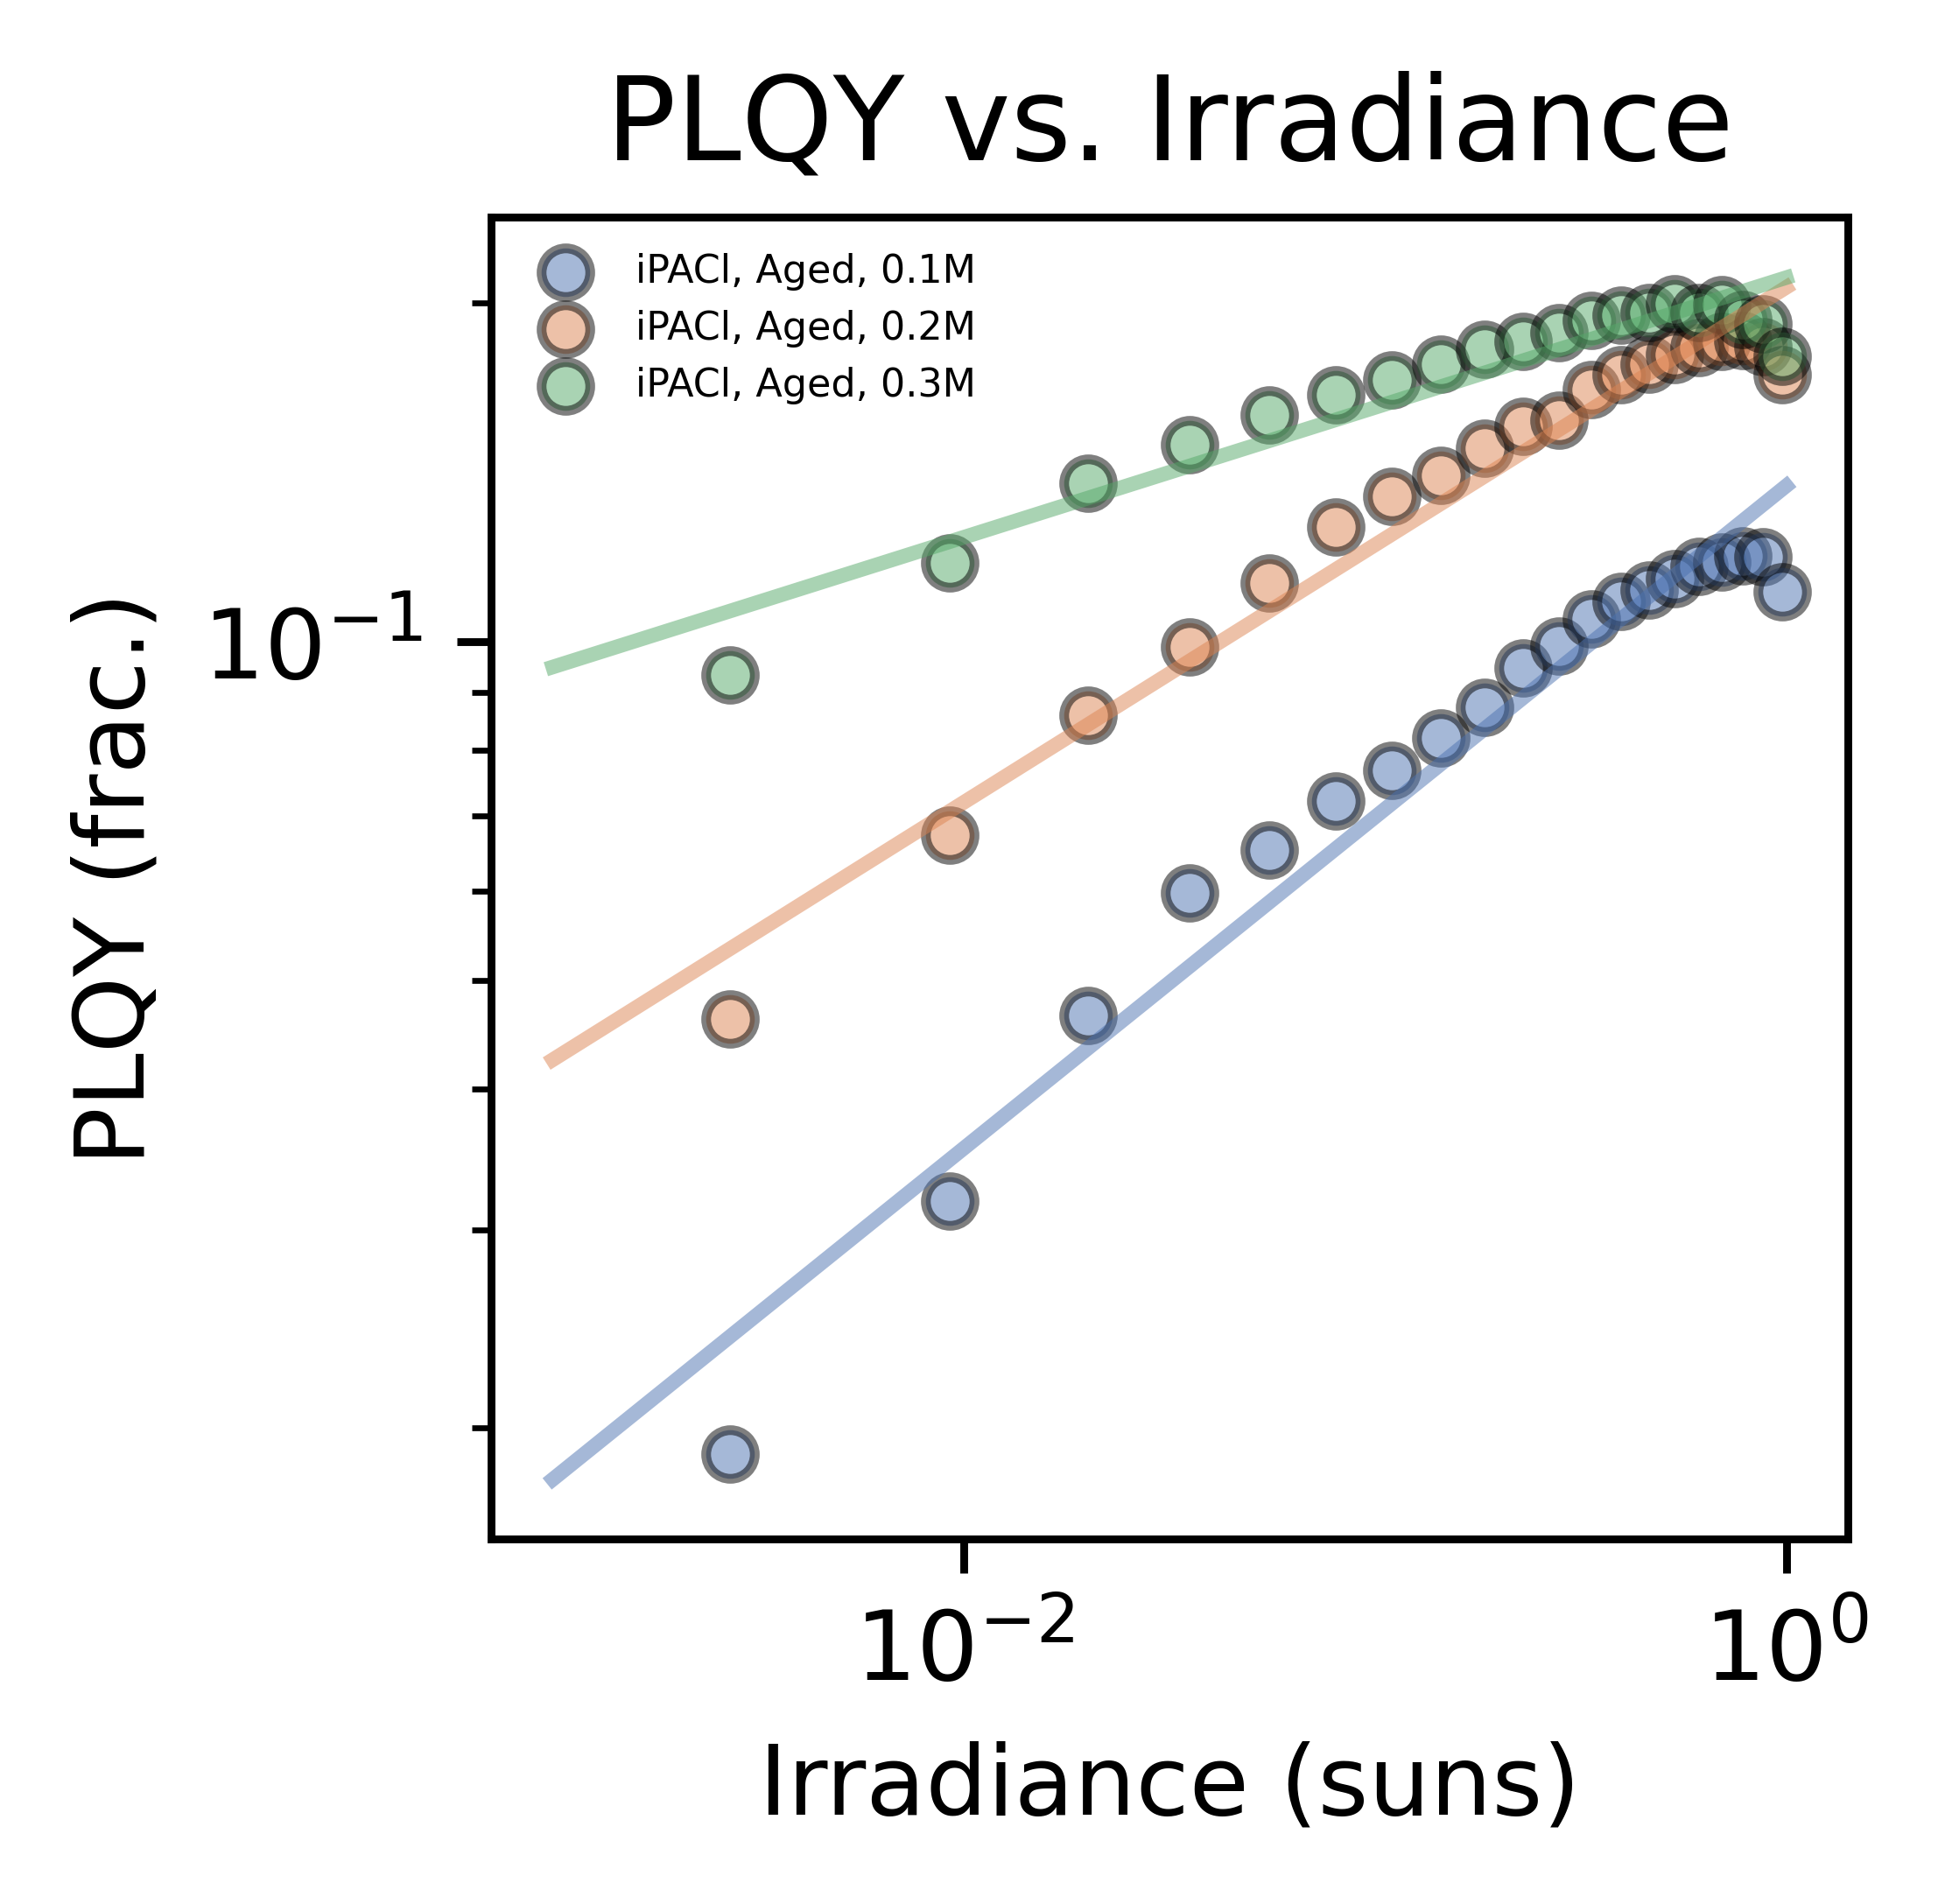

In [105]:
# Set up the figure with desired size and resolution
plt.figure(figsize=(2.5, 2.5), dpi=400)

# Dictionaries to store irradiance and PLQY values
irrs = {}
plqys = {}

# Loop through each sample to plot the data
for i, n in enumerate(sample_names):

    # Calculate x and y values
    x_values = np.log10(powers[n] / (0.1256 * 35))[1:]
    y_values = np.log10(np.array([demello_result[n][k][0] for k in demello_result[n].keys()]))[1:]
    
    # Fit the data to a linear model
    slope, intercept = np.polyfit(x_values, y_values, 1)
    
    # Plot the data points using the Seaborn colors
    plt.scatter(10**x_values, 10**y_values, alpha=0.5, edgecolors='black', s=25, 
                label=n.replace('_', ', ').replace('0p', '0.'), color=colors_seaborn[n])
    
    # Plot the linear fit
    x_fit = np.linspace(-3, 0, 100)
    plt.plot(10**x_fit, 10**(slope * x_fit + intercept), linestyle='solid', alpha=0.5, color=colors_seaborn[n])

# Set plot scales, labels, limits, and legend
plt.yscale('log')
plt.xscale('log')
plt.ylabel('PLQY (frac.)')
#plt.ylim(5e-3, 1)
#plt.xlim(1e-3, 1.2)
plt.xlabel('Irradiance (suns)')
plt.legend(fontsize=4, frameon=False, loc='best')
plt.title("PLQY vs. Irradiance")

# Convert dictionaries to arrays (if needed later)
plqys_array = np.array(list(plqys.values()))
irrs_array = np.array(list(irrs.values()))

# Option to Save the figure
#plt.savefig('PLQY.png', facecolor='white', bbox_inches='tight')


# Irradiance vs. Ideality Factor

Ideality Factor of iPACl_Aged_0p1M: 0.93
Ideality Factor of iPACl_Aged_0p2M: 0.68
Ideality Factor of iPACl_Aged_0p3M: 0.40


Text(0.5, 1.0, 'Ideality Factor vs. Irradiance')

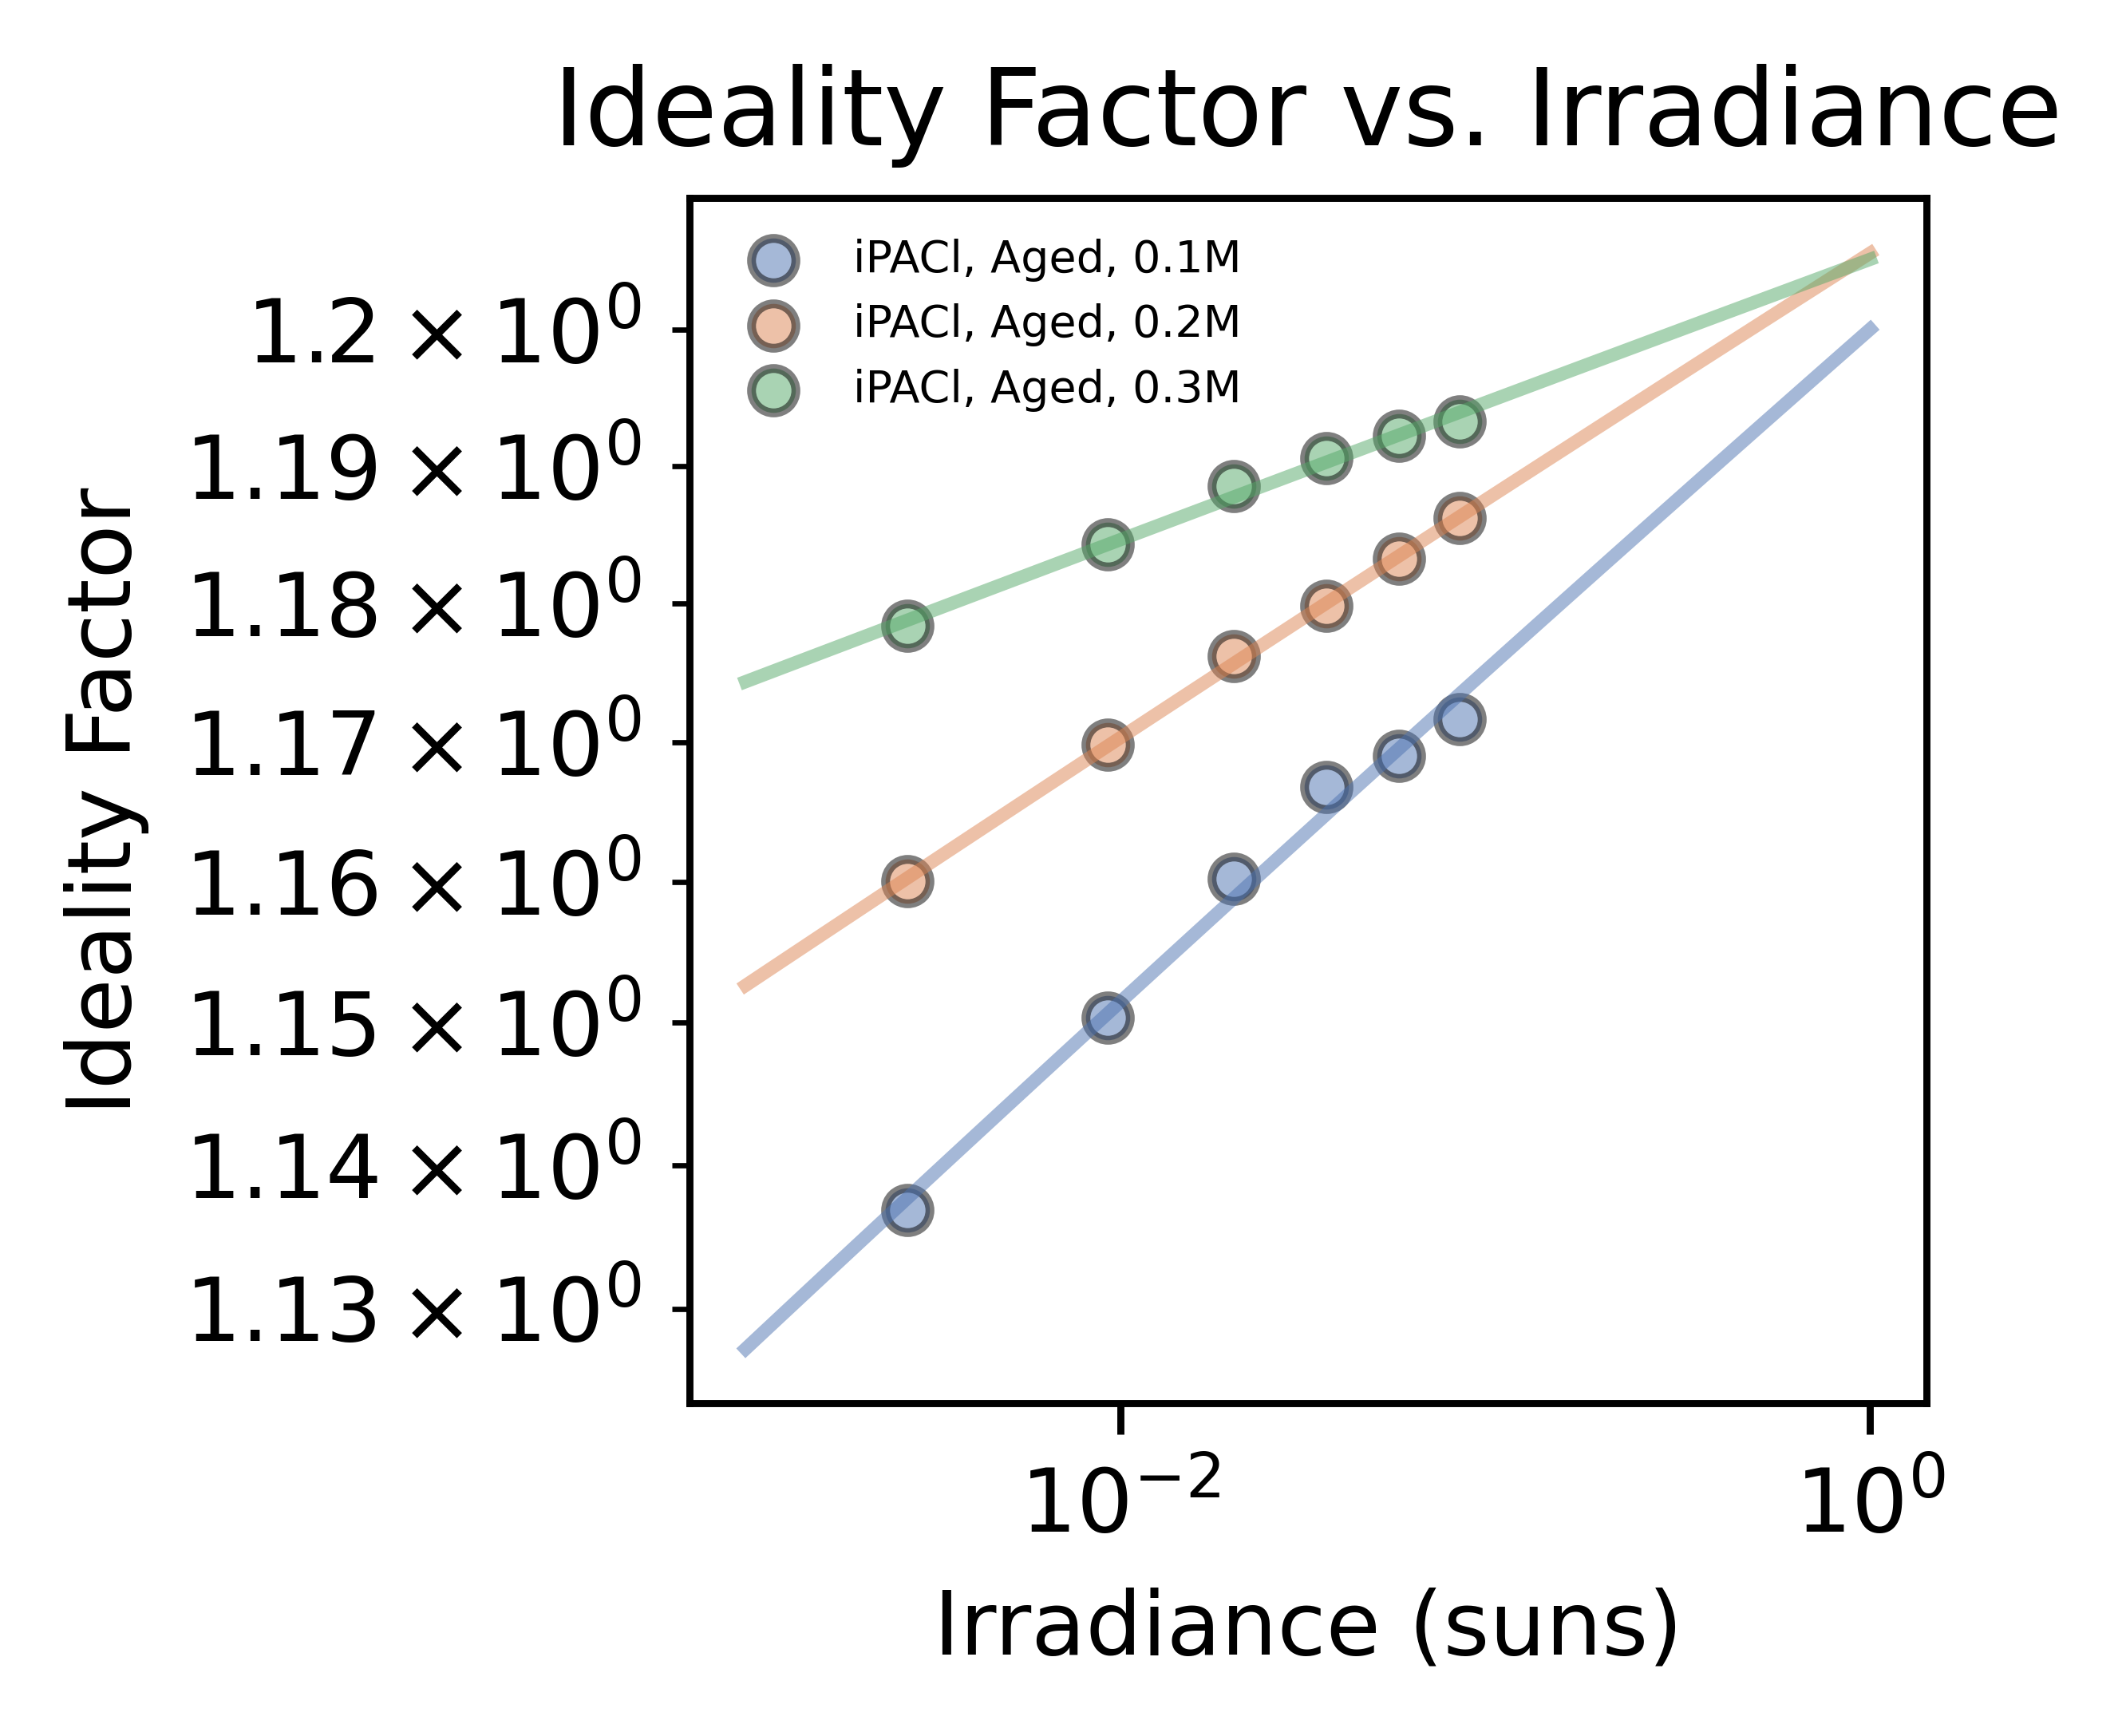

In [106]:
# Set up the figure with desired size and resolution
plt.figure(figsize=(2.5, 2.5), dpi=400)

# Dictionary to store irradiance values
irrs = {}

# List to store calculated ideality factors
ideality_factors = []

# Loop through each sample to plot the data
for i, n in enumerate(sample_names):

    # Calculate x values
    x_values = np.log10(powers[n] / (0.1256 * 35))[1:7]
    
    # Calculate y values (ideality factors)
    y_values = 1.24 + 0.026 * np.log(np.array([demello_result[n][k][0] for k in demello_result[n].keys()])[1:7])
    
    # Fit the data to a linear model
    slope, intercept = np.polyfit(x_values, y_values, 1)
    ideality_factor = slope / 0.026
    
    # Store the calculated ideality factor
    ideality_factors.append(ideality_factor)
    
    # Plot the data points using the Seaborn colors
    plt.scatter(10**x_values, y_values, alpha=0.5, edgecolors='black', s=25, 
                label=n.replace('_', ', ').replace('0p', '0.'), color=colors_seaborn[n])
    
    # Plot the linear fit
    x_fit = np.linspace(-3, 0, 100)
    plt.plot(10**x_fit, slope * x_fit + intercept, linestyle='solid', alpha=0.5, color=colors_seaborn[n])

    print(f'Ideality Factor of {n}: {ideality_factor:.2f}')

# Set plot scales, labels, limits, and legend
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1.1, 1.25)
#plt.xlim(1e-3, 1)
plt.xlabel('Irradiance (suns)')
plt.ylabel('Ideality Factor')
plt.legend(fontsize=5, frameon=False, loc='best')
plt.title("Ideality Factor vs. Irradiance")

# Option to Save the figure
#plt.savefig('Ideality.png', facecolor='white', bbox_inches='tight')


# Pseudo JV curves

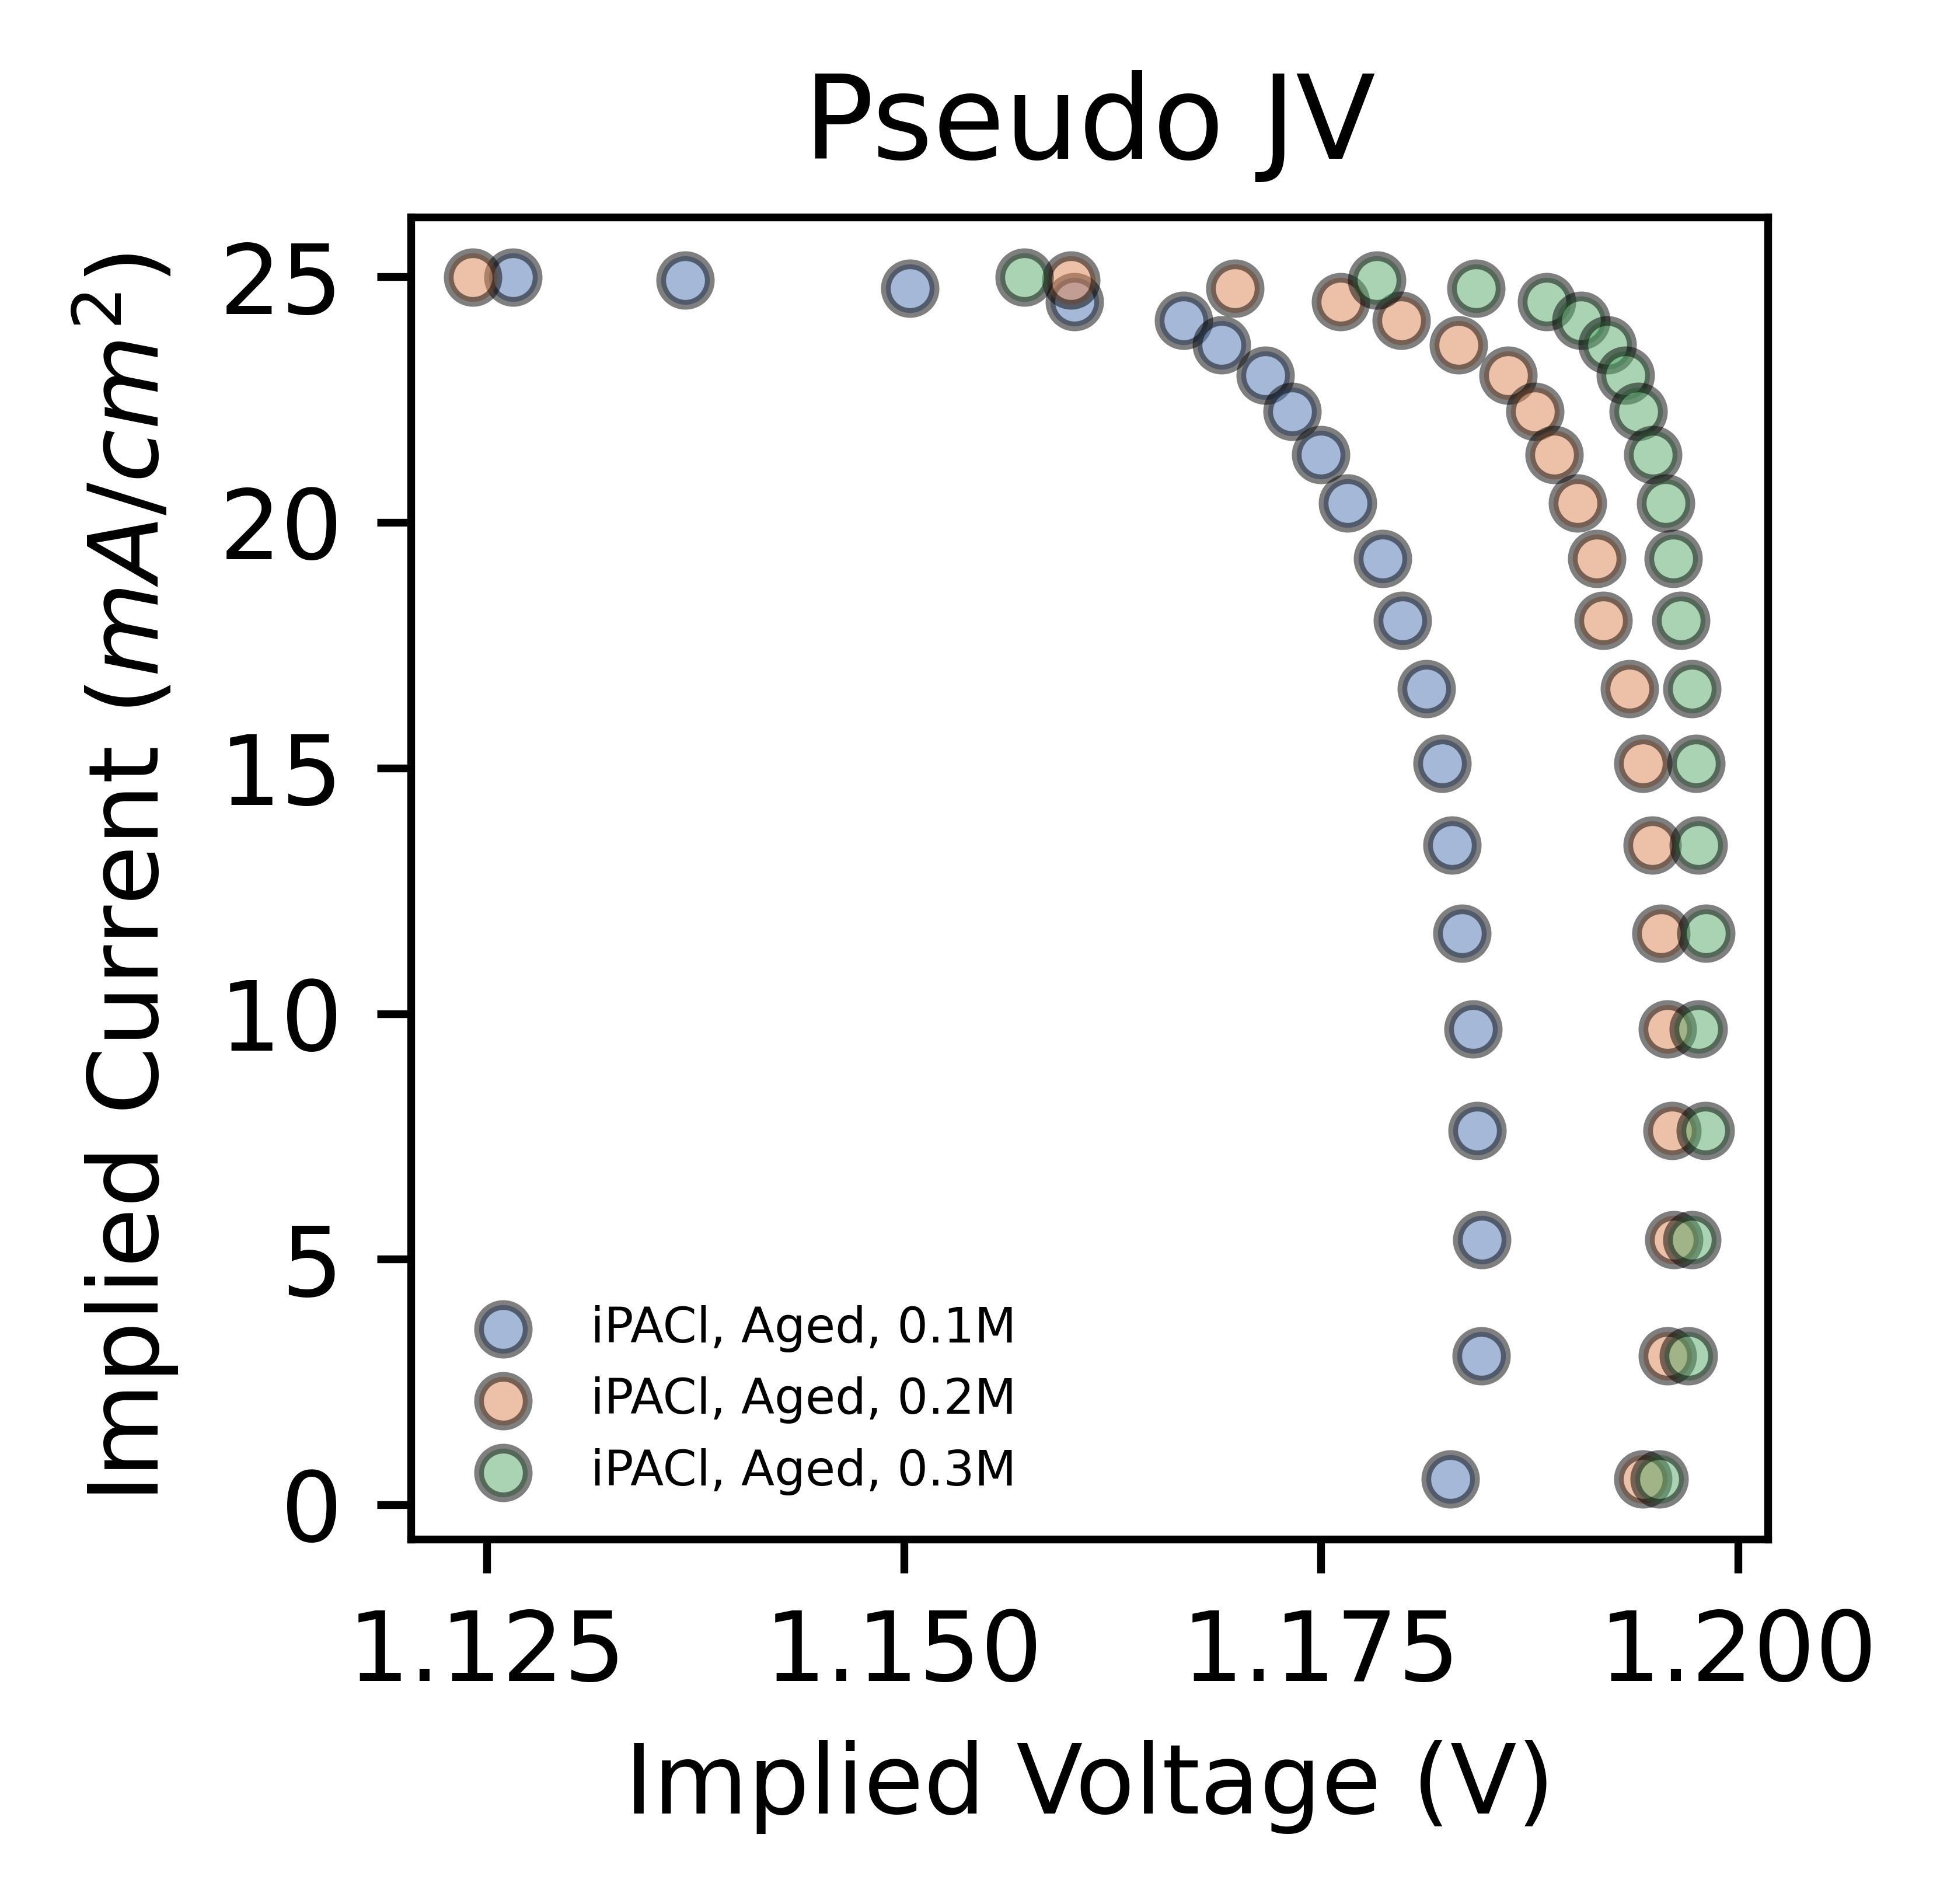

In [107]:
# Set up the figure with desired size and resolution
plt.figure(figsize=(2.5, 2.5), dpi=600)

# Loop through each sample to plot the data
for i, n in enumerate(sample_names):

    # Calculate y values (Implied Current)
    y_values = 25 * powers[n] / (0.1256 * 35)
    
    # Calculate x values (Implied Voltage)
    x_values = 1.24 + 0.026 * np.log(np.array([demello_result[n][k][0] for k in demello_result[n].keys()]))
    
    # Plot the data points using the Seaborn colors
    plt.scatter(x_values, 25 - y_values, alpha=0.5, edgecolors='black', s=25, 
                label=n.replace('_', ', ').replace('0p', '0.'), color=colors_seaborn[n])

# Set labels, limits, title, and legend
plt.ylabel('Implied Current ($mA/cm^2$)')
#plt.ylim(0, 26)
#plt.xlim(1.1, 1.20)
plt.xlabel('Implied Voltage (V)')
plt.title("Pseudo JV")
plt.legend(fontsize=5, frameon=False, loc = 'best')

# Save the figure
plt.savefig("pseudo_JV.png", facecolor='white', bbox_inches='tight')
